# Evaluation of Retrosynthesis models

Files needed:
* target files:
    * precursors-train.txt: tokenized train set of the precursors
    * product-train.txt: tokenized train set of the product
    * class-multi-train.txt: tokenized file of the reaction class (ex 1.2.1 -> 1 1.2 1.2.1)

* retro model predictions for EACH experiment (baseline + all the cleaned):
    * can_**example_name**_step_xxxxx.out.txt: file with the canonical topN predictions
    * **example_name**_step_xxxxx.out.txt_gold_score: file with the gold scores of the target
    * **example_name**_step_xxxxx.out.txt_log_probs: files with the log probabilites of the topN predictions
    
* forward model predictions (run on the retro model predictions) for EACH experiment (baseline + all the cleaned):
    * can_fwd_can_**example_name**_step_xxxxx.out.txt: file with the canonical top1 predictions ( one for each of the topN predictions of the retro)
    * fwd_can_**example_name**_step_xxxxx.out.txt_gold_score: file with the gold scores of the target
    * fwd_can_**example_name**_step_xxxxx.out.txt_log_probs: files with the log probabilites of the top1 predictions ( one for each of the topN predictions of the retro)
    
* classification model predictions (run on the retro model rxn predictions) for EACH experiment (baseline + all the cleaned):
    * classes_rxn_**example_name**_step_xxxxx.out.txt: file with the top1 classes predicted ( one for each of the topN predictions of the retro)

Variables to set: **datapath**, **retropaths** (list), **forwardpaths** (list), **classificationpaths** (list), **baseline_retropath**, **baseline_forwardpath**, **baseline_classificationpath**

Outputs:
* "figures/": the plots

In [1]:
savepath='figures'

RDKit WARNING: [12:00:51] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from onmt_utils.RetroEvalModel import *
from onmt_utils.plotter_topn import topn , topn_byclass
from onmt_utils.plotter_likelihoods import likelihoods_pdf, likelihoods_pdf_oneclass, \
likelihoods_pdf_allclasses, likelihoods_cdf_allclasses
from onmt_utils.plotter_metrics import CJSD_vs_bins
from onmt_utils.plotter_retrometrics import bar_plot_metrics

In [3]:
#Lambda function to costumize the experiment names 

get_names = lambda base_names: ['_'.join(b.split('_')[6:7]) for b in base_names]


In [4]:
datapath = "path/to/target/files"

re = RetroEvalModel(datapath,'dataset_name', split='test', n_best=10)

retropaths = [ "path/to/retro/model1", "path/to/retro/model1" ]
forwardpaths = [ "path/to/forward/inference/of/model1", "path/to/forward/inference/of/model2" ]
classificationpaths = [ "path/to/classification/inference/of/model1", "path/to/classification/inference/of/model2" ]

for i in range(len(retropaths)):
    re.add_experiment( retropaths[i], forwardpaths[i], classificationpaths[i], func = get_names)

#Add baseline results for comparison

baseline_retropath = "path/to/retro/baseline"
baseline_forwardpath = "path/to/forward/inference/of/baseline"
baseline_classificationpath = "path/to/classification/inference/of/baseline"
re.add_experiment( baseline_retropath, baseline_forwardpath, baseline_classificationpath, func = get_names)
            
re.print_experiments()


Experiments list for split test: 
25perc
pistachioonly


### TOP10 accuracy

In [5]:
print(re.get_allexp_top_n_accuracy(topn=10))


([23.784474108310274, 24.254264603034635], ['25perc', 'pistachioonly'])


## Retrosynthesis evaluation metrics


### Coverage

In [5]:
cov, labels = re.get_coverage_allexp()
cov, labels


([97.05886824581141, 95.71335178033874], ['25perc', 'pistachioonly'])

### Round trip accuracy 

In [6]:
rt_acc, labels = re.get_round_trip_accuracy_allexp()
rt_acc, labels


([86.21879466050414, 73.27492626265695], ['25perc', 'pistachioonly'])

### Class Diversity

In [7]:
class_div, _ = re.get_class_diversity_allexp()
class_div, labels


([1.627656824885213, 1.6098078268008635], ['25perc', 'pistachioonly'])

### CJSD

In [8]:
# 12 classes
result = re.get_CJSD_allexp(superclasses=range(12), x_min=0.5, nbins = 100)


In [9]:
CJSD = result[0]
labels = result[-1]
CJSD, labels

([0.0030199344819879376, 0.005788989791869273], ['25perc', 'pistachioonly'])

In [10]:
# 11 classes
result = re.get_CJSD_allexp(superclasses=range(11), x_min=0.5, nbins = 100)

CJSD_no11 = result[0]
labels = result[-1]
CJSD_no11, labels


([0.000636185189162905, 0.0008375056207282627], ['25perc', 'pistachioonly'])

### Plot of the retro metrics for the two models

In [11]:
from matplotlib import cm
import matplotlib.pyplot as plt
from onmt_utils.plotter_helper import autolabel
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

def bar_plot_metrics(labels, cov, class_div, rt_acc, CJSD, CJSD_nocl11, split, save=False, png_path='', figsize=(6, 5), font=8, vert_off=(0,3)):

    labels = ['cleaned','baseline']
    cov = cov
    class_div = class_div
    rt_acc = rt_acc
    CJSD_div = [np.sqrt(elem)*1e2 for elem in CJSD]
    CJSD_div_nocl11 = [np.sqrt(elem)*1e2 for elem in CJSD_nocl11]
    
    col = colors = [ cm.twilight(x) for x in np.linspace(0, 1.0, 10) ]

    if labels:                           #if the split is not empty

        plt. figure()
        x = np.arange(len(labels))  # the label locations
        width = 0.8  # the width of the bars
        lab_width = width/4

        fig, ax = plt.subplots(figsize=figsize)
        ax2 = ax.twinx()
        rects1 = ax.bar(x - width/2 + lab_width/2, cov, lab_width, label='coverage', color=col[0])
        rects2 = ax.bar(x - width/4 + lab_width/2, rt_acc, lab_width, label='RT accuracy', color = col[1])
        rects3 = ax2.bar(x + width/4 - lab_width/2, CJSD_div, lab_width, label='$\sqrt{CJSD}$*1e2', color = col[2])
        rects4 = ax2.bar(x + width/2 - lab_width/2, CJSD_div_nocl11, lab_width, label='$\sqrt{CJSD_{R}}$*1e2', color = col[3])
        rects5 = ax2.bar(x + width/2 + lab_width/2, class_div, lab_width, label='class diversity', color = col[4])
        ax2.set_ylabel('abs', color='tab:red',fontsize=font)  # we already handle the x-label with ax1
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('%',fontsize=font)
        ax.set_ylim(0.0, 115.0)
        ax2.set_ylim(0.0, 10.0)
        #ax.set_title(f'Metrics {split} set')
        ax.set_xticks(x)
        ax.set_xticklabels(labels,rotation='horizontal',fontsize=font)
        ax.legend(prop=fontP,loc='upper right', bbox_to_anchor=(0.45, -0.15),
          fancybox=True, shadow=True, ncol=2)
        ax2.legend(prop=fontP,loc='upper left', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=2)

        autolabel(rects1, ax, vert_off=vert_off, font=font)
        autolabel(rects2, ax, vert_off=vert_off, font=font)
        autolabel(rects3, ax2, vert_off=vert_off, font=font)
        autolabel(rects4, ax2, vert_off=vert_off, font=font)
        autolabel(rects5, ax2, vert_off=vert_off, font=font)

        if save == True:
            %mkdir 'figures'
            plt.savefig(png_path + f'/Metrics_byexp_{split}.pdf', bbox_inches='tight')

    plt.show()

<Figure size 432x288 with 0 Axes>

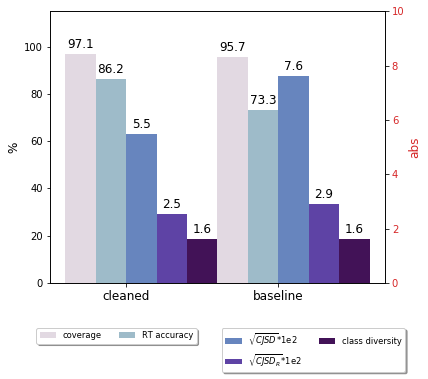

In [12]:
bar_plot_metrics(labels, cov, class_div, rt_acc, CJSD, CJSD_no11, split = 'test', save=True, \
                 png_path=savepath, font=12)
